## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST ("Modified National Institute of Standards and Technology") dataset 

In [7]:
from sklearn.datasets import fetch_openml

# fetch_openml() returns a Pandas DataFrame by default. 
# To avoid this and keep the same code as in the book, we use as_frame=False.
    # the data is returned as a NumPy array,

# 'mnist_784' is the name of the dataset to download
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [8]:
28 * 28

784

Saving figure some_digit_plot


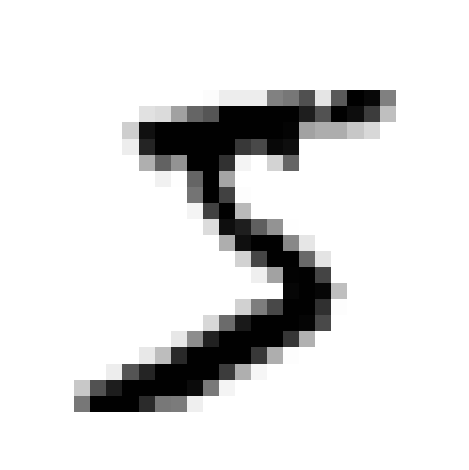

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

'''
- X contains a NumPy array with 70,000 rows (one for each image) and 784 columns (one for each pixel). 
- By selecting the first row of X with X[0], we get the pixel values of the first digit in the dataset.
'''
some_digit = X[0]
# This line reshapes the array into a 2D array with dimensions 28x28, which corresponds to the original dimensions of the digit image.
some_digit_image = some_digit.reshape(28, 28)
'''
- Matplotlib library to display the digit image
- cmap=mpl.cm.binary is used to specify that the colormap should be black and white 
    - (with black representing low pixel values and white representing high pixel values).
'''
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [12]:
# The target value
y[0]

'5'

In [14]:
y = y.astype(np.uint8)

In [15]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [16]:
# Big Image
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


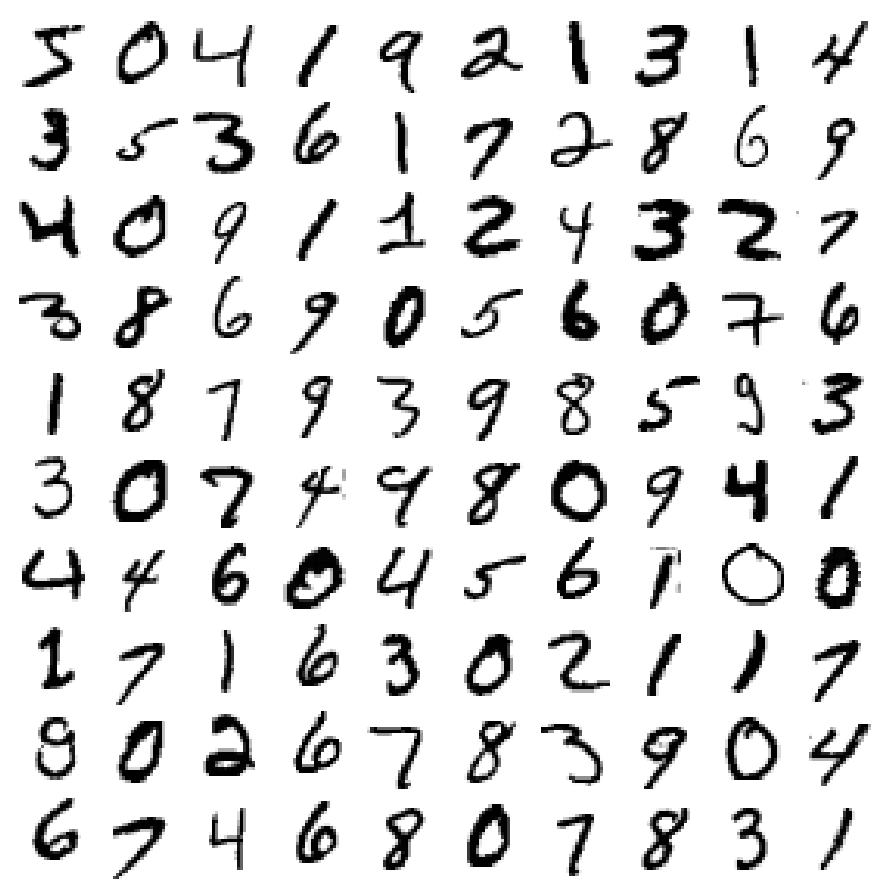

In [17]:
# Plot big image
plt.figure(figsize=(9,9))
# 100 images at once
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [18]:
# y = y.astype(np.uint8)
y[0]

5

### Split into Train & Test Set

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train a Binary Classifier

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [21]:
from sklearn.linear_model import SGDClassifier

'''
- The SGDClassifier is an implementation of the stochastic gradient descent algorithm for linear classifiers.
- The tol parameter sets the stopping criterion for the algorithm, which is the tolerance for the change in the loss function between iterations. 
    - If the change in the loss is less than this tolerance, the algorithm will stop.
'''
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# Train the SGDClassifier Model
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [22]:
sgd_clf.predict([some_digit])

array([ True])

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Performance Measure

### Measuring Accuracy Using Cross-Validation

### (StratifiedKFold)

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
'''
- The StratifiedKFold is a cross-validation technique that splits the data into n_splits number of folds while preserving 
        the percentage of samples for each class. 
- This is useful when you have imbalanced class distributions, where you want to ensure that the proportion of each class 
        is maintained in each fold.
- The n_splits parameter sets the number of folds to create. In this case, it is set to 3, so the data will be split into three folds.
- The shuffle parameter is set to True, which means that the data will be shuffled before the splits are made

** 
    Overall, this line of code creates a cross-validation object that splits the data into folds while preserving the class proportions and 
    randomizes the order of the data before splitting. This object can be used with scikit-learn's cross_val_score function to evaluate 
    the performance of a model.
**
'''
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# generates indices to split the data into train and test sets for each fold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # ensure that the model is trained on the current fold and not affected by the training on previous folds.
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    # The classifier is trained
    clone_clf.fit(X_train_folds, y_train_folds)
    # The classifier makes predictions on the test data
    y_pred = clone_clf.predict(X_test_fold)
    # The sum() function is used to count the number of correct predictions.
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


### (Never5Classifier)

In [25]:
# The BaseEstimator class is a base class for all scikit-learn estimators, which provides default implementations for common methods like get_params() and set_params().
from sklearn.base import BaseEstimator

'''
**
     This classifier can be useful as a baseline for comparison with more complex models
**
- binary classifier that always predicts that an input does not contain the digit 5
'''
class Never5Classifier(BaseEstimator):
    # method does nothing
    def fit(self, X, y=None):
        pass
    # Never5Classifier classifier always predicts that an input does not contain the digit 5, regardless of its actual content.
    #  returned array contains boolean values.
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [26]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [28]:
from sklearn.model_selection import cross_val_predict

# sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# sgd_clf.fit(X_train, y_train_5)

'''
It's different to "cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")"
'''
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [30]:
# pretend we reached perfection
y_train_perfect_predictions = y_train_5  
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision

In [31]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [33]:
# Same result as 'precision_score()'
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

### Recall

In [34]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [35]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

### F1 Score

In [36]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [37]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## Precision & Recall Trade-off

In [48]:
# sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# sgd_clf.fit(X_train, y_train_5)

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

#### Set Threshold

In [41]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [42]:
y_some_digit_pred

array([ True])

In [54]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [56]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [58]:
from sklearn.metrics import precision_recall_curve

# Generate a values for 'precisions' / 'recalls' / 'thresholds'
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#### With Threshold

Saving figure precision_recall_vs_threshold_plot


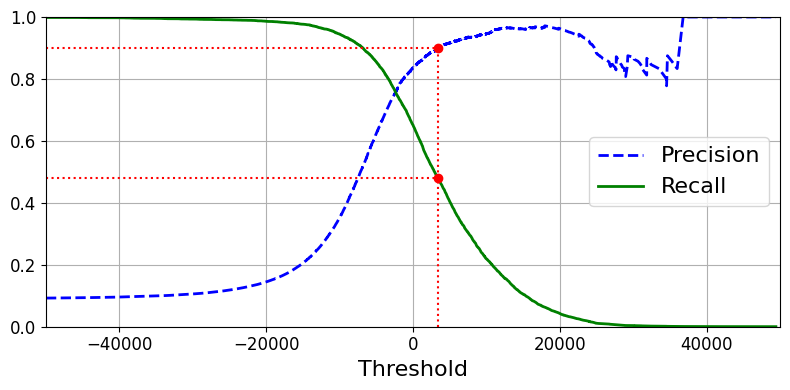

In [67]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


# recall_90_precision: 0.4799852425751706
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
# threshold_90_precision: 3370.0194991439594
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# Vertical line using 2 points -> [x1,x2],[y1,y2]
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
# Top Horizontal line using 2 points -> [x1,x2],[y1,y2]
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
# Bottom Horizontal line using 2 points -> [x1,x2],[y1,y2]
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
# Red Dots
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [68]:
# y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
(y_train_pred == (y_scores > 0)).all()

True

#### Threshold Seperated

Saving figure precision_vs_recall_plot


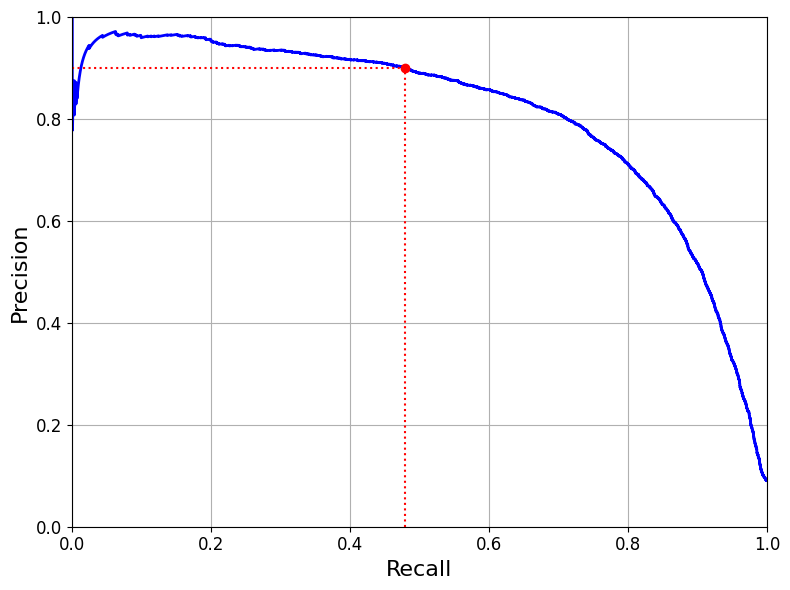

In [70]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
# precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_vs_recall(precisions, recalls)
# recall_90_precision: 0.4799852425751706
# recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
# Vertical Dotted Line
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
# Horizontal Dotted Line
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
# Red Dot
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [73]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

#### Values with Threshold

In [75]:
# y_scores = array([  1200.93051237, -26883.79202424, -33072.03475406, ...,  13272.12718981,  -7258.47203373, -16877.50840447])
# y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [76]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [77]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706